In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
plt.style.use('default')

df=pd.read_csv('/datc/opschaler/combined_gas_smart_weather_dfs/processed/P01S01W8655_hour.csv',header=0,delimiter='\t', parse_dates=['datetime'])
df=df.set_index(['datetime'])
df['gasPower']=df['gasPower']*10
dwelling_id = 'P01S01W8655'

In [2]:
sample_rate = '1D'
def resample_df(df, sample_rate, combine_all_dwellings=False):
    """
    Resampled a (un)processed dataframe to the specified sample_rate.
    Input is a (un)processed df.
    Input df may also be multiple dwelling dfs combined.
    Sample rate must be a string. 
    For example '1H', '1D', '60s'.
    
    Combine all dwellings: resamples the df and ignores the fact that there are unique dwellings.
    
    TODO: add std to ePower, gasPower when combine_all_dwellings=False
    """
    def resample_dwelling(df, sample_rate, dwelling_id):
        df = df.resample(sample_rate).mean() # resample to rest by mean
        df['dwelling'] = dwelling_id
        return df
        
                      
    resampled_dwellings = []
    
    if combine_all_dwellings: # Ignore dwelling_ids
        df = df.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter'], axis=1) # Drop columns because they are meaningless when ignoring dwelling ids
        resampled_df = resample_dwelling(df, sample_rate, 'All dwellings')
        resampled_dwellings.append(resampled_df)
    else:
        dwellings = df['dwelling'].unique() # Get dwelling ids
        for dwelling_id in tqdm(dwellings):
            dwelling_df = df[df['dwelling'] == dwelling_id] # Get the data from only that dwelling_id
            resampled_dwelling = resample_dwelling(dwelling_df, sample_rate, dwelling_id)
            resampled_dwellings.append(resampled_dwelling)
    
    resampled_df = pd.concat(resampled_dwellings)
    
    return resampled_df

rdf=resample_df(df,sample_rate)
trdf = rdf[rdf['T'] < 16]

100%|██████████| 1/1 [00:00<00:00, 41.67it/s]


In [3]:

rdf=rdf[np.isfinite(rdf['gasPower'])]
trdf=trdf[np.isfinite(trdf['gasPower'])]

In [4]:
rdf['T-1'] = rdf['T'].shift(1)

In [5]:
rdf.head()

,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,gasMeter,DD,DR,FF,...,SQ,T,T10,TD,U,VV,WW,gasPower,dwelling,T-1
datetime,,,,,,,,,,,,,,,,,,,,,
2017-04-24,780.317000,0.0,736.981167,0.0,425.912710,0.0,1592.684833,266.836110,142.333333,5.104167,...,0.308364,10.955556,11.359722,6.690278,75.138890,29418.194500,28.125000,2.013716,P01S01W8655,NaN
2017-04-25,784.964250,0.0,738.217500,0.0,365.682568,0.0,1595.581708,285.680485,47.416667,5.478194,...,4.004910,6.503472,6.373403,1.977500,72.906250,36118.680500,23.550000,1.501211,P01S01W8655,10.955556
2017-04-26,792.001667,0.0,739.756625,0.0,363.442245,0.0,1601.344913,261.319517,39.000000,2.983042,...,4.090413,6.069097,5.823472,2.151667,76.909722,35074.527917,11.470833,3.757324,P01S01W8655,6.503472
2017-04-27,796.967000,0.0,744.674917,0.0,411.699121,0.0,1608.707583,233.521111,17.708333,2.968375,...,2.682295,6.181319,5.922500,2.129722,76.137500,36665.555917,11.267361,2.139994,P01S01W8655,6.069097
2017-04-28,800.575875,0.0,751.724250,0.0,511.259890,0.0,1614.828083,266.770347,58.366667,2.997917,...,2.737647,7.958750,7.910486,4.364167,78.612500,33648.791625,18.394445,2.516632,P01S01W8655,6.181319


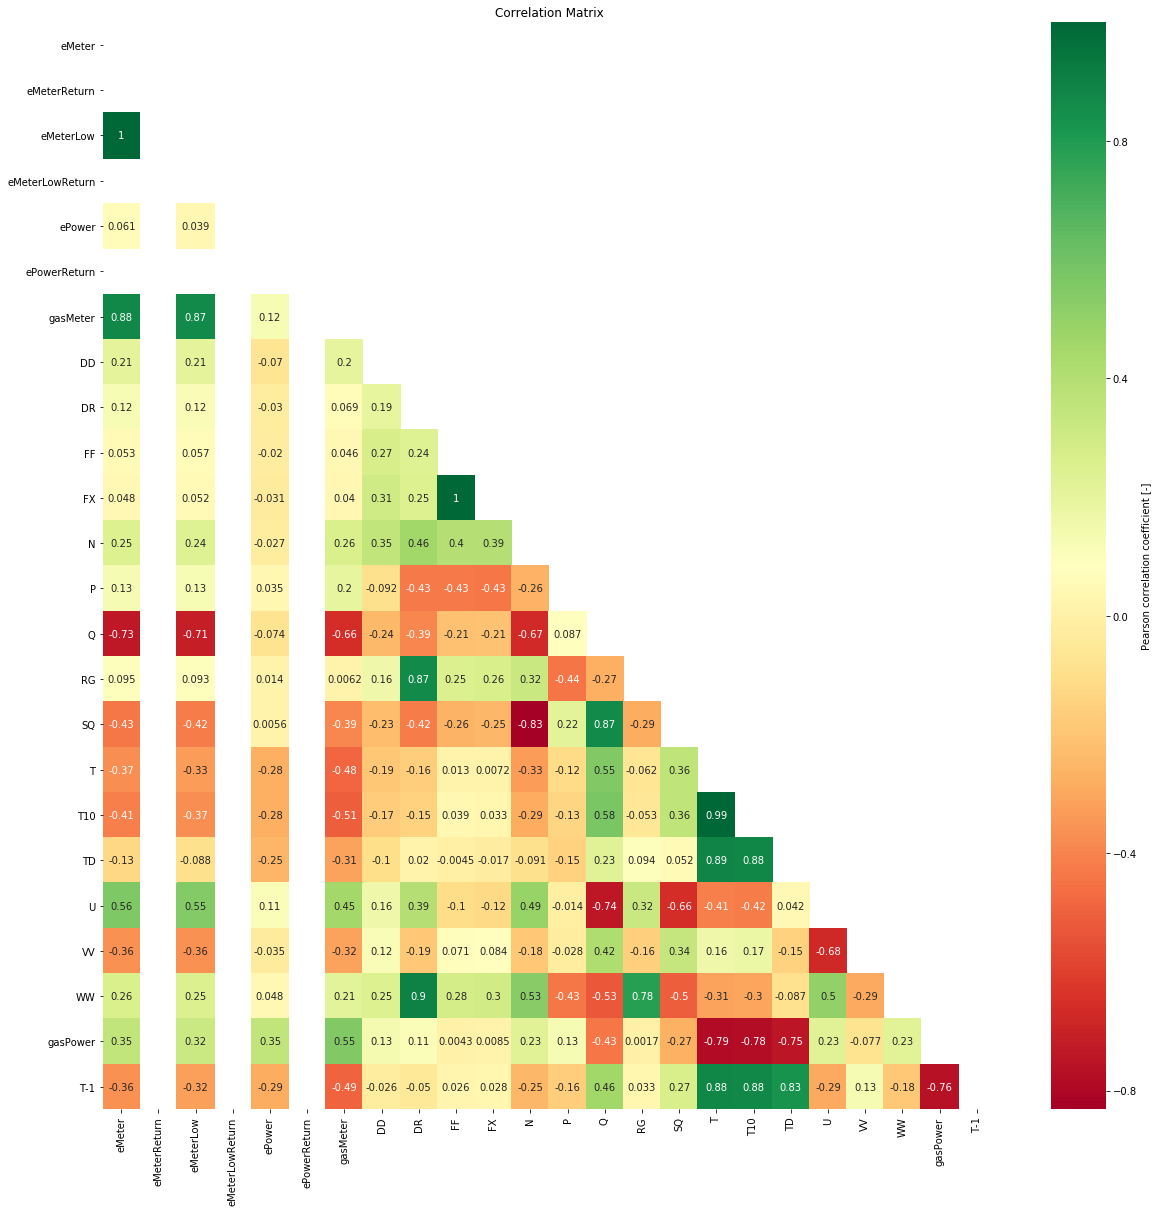

In [7]:
corr = rdf.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr, mask=mask, square=False, cmap='RdYlGn', annot=True, ax=ax,
             cbar_kws={'label':'Pearson correlation coefficient [-]'})

plt.title('Correlation Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.savefig('correlationmatrix.png', dpi=500)
plt.show()

In [7]:
rdf=rdf.dropna()

In [8]:
rdf['hour'] = rdf.index.hour #create column containing the hour
rdf['dayofweek'] = rdf.index.dayofweek #Create column containing the day of the week

In [9]:
columns_to_cat = ['hour', 'dayofweek']
rdf[columns_to_cat] = rdf[columns_to_cat].astype('category') # change datetypes to category

rdf = pd.get_dummies(rdf, columns=columns_to_cat) # One hot encoding the categories

In [10]:
rdf.head()

,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,gasMeter,DD,DR,FF,...,dwelling,T-1,hour_0,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
datetime,,,,,,,,,,,,,,,,,,,,,
2017-04-25,784.964250,0.0,738.217500,0.0,365.682568,0.0,1595.581708,285.680485,47.416667,5.478194,...,P01S01W8655,10.955556,1,0,1,0,0,0,0,0
2017-04-26,792.001667,0.0,739.756625,0.0,363.442245,0.0,1601.344913,261.319517,39.000000,2.983042,...,P01S01W8655,6.503472,1,0,0,1,0,0,0,0
2017-04-27,796.967000,0.0,744.674917,0.0,411.699121,0.0,1608.707583,233.521111,17.708333,2.968375,...,P01S01W8655,6.069097,1,0,0,0,1,0,0,0
2017-04-28,800.575875,0.0,751.724250,0.0,511.259890,0.0,1614.828083,266.770347,58.366667,2.997917,...,P01S01W8655,6.181319,1,0,0,0,0,1,0,0
2017-04-29,807.578000,0.0,755.794250,0.0,354.837559,0.0,1620.309522,160.518265,0.000000,1.829861,...,P01S01W8655,7.958750,1,0,0,0,0,0,1,0


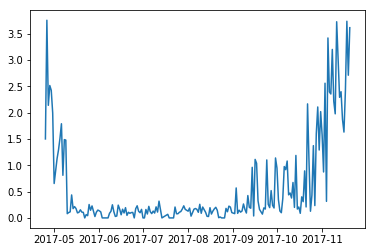

In [11]:
plt.plot(rdf.index,rdf['gasPower'])
plt.show()

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X = rdf[['T','T-1','dayofweek_0','dayofweek_1','dayofweek_2','dayofweek_3','dayofweek_4','dayofweek_5','dayofweek_6']]
y = rdf[['gasPower']]

# X = np.array(X).reshape(-1,9) # Reshape because sklearn wants you to
# y = np.array(y).reshape(-1,1)

test_size = 0.5

split_index = int(rdf.shape[0]*test_size) # the index at which to split df into train and test

X_train = X[:split_index]
y_train = y[:split_index]

X_test = X[split_index:]
y_test = y[split_index:]
        
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [13]:
len(X_train)

103

In [14]:
model.score(X_test, y_test)

0.5443791977038371

In [15]:
print(model.get_params(deep=True))

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}


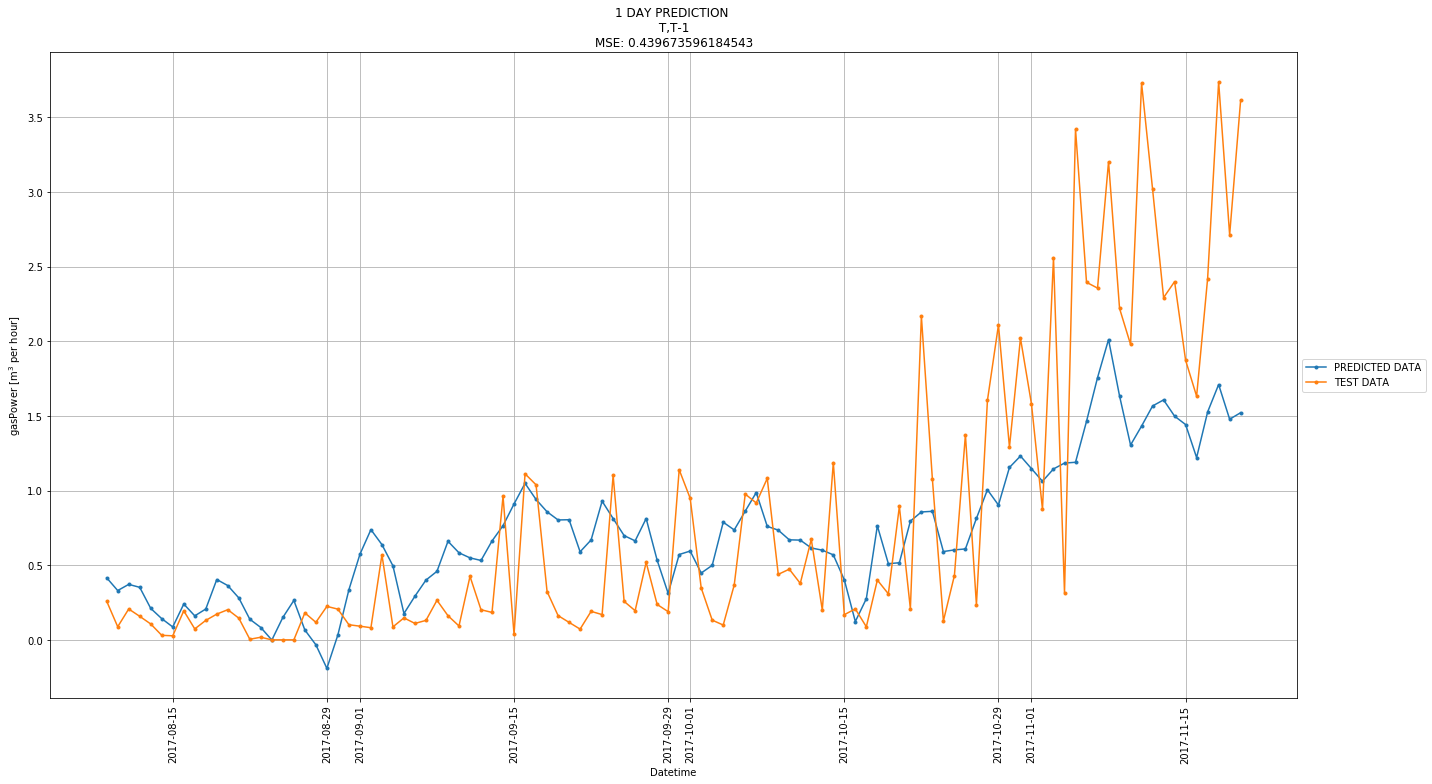

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.dates
X_datetime=rdf.index[:len(X_train)]
X1_datetime=rdf.index[len(X_train):]
# X_datetime = matplotlib.dates.date2num(X_datetime)
# X1_datetime= matplotlib.dates.date2num(X1_datetime)

Y_prediction=model.predict(X_test)

# %matplotlib notebook
%matplotlib inline
plt.figure(figsize=(20,11))
# plt.plot(X_datetime,y_train,'.-',label='TRAINED DATA')
plt.plot(X1_datetime,Y_prediction,'.-',label='PREDICTED DATA')     
plt.plot(X1_datetime,y_test,'.-',label='TEST DATA')

plt.grid(True)
plt.title('1 DAY PREDICTION \n T,T-1 \nMSE: '+ str(mean_squared_error(y_test,Y_prediction)))
plt.xlabel( 'Datetime')
plt.xticks(rotation='vertical' )
plt.ylabel('gasPower [m$^3$ per hour]')
# plt.xlim(X1_datetime[0],X1_datetime[-1])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()
plt.savefig('MVR result daily[T,T-1].png', dpi=1200)